# Classifying Handwritten Digits with Neural Networks

Colab link: https://colab.research.google.com/notebooks/mlcc/multi-class_classification_of_handwritten_digits.ipynb

![img](https://www.tensorflow.org/images/MNIST.png)

**Learning Objectives:**
  * Train both a linear model and a neural network to classify handwritten digits from the classic [MNIST](http://yann.lecun.com/exdb/mnist/) data set
  * Compare the performance of the linear and neural network classification models
  * Visualize the weights of a neural-network hidden layer


Our goal is to map each input image to the correct numeric digit. We will create a NN with a few hidden layers and a Softmax layer at the top to select the winning class.

In [0]:
from __future__ import print_function

import glob
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

mnist_df = pd.read_csv( "https://download.mlcc.google.com/mledu-datasets/mnist_train_small.csv", sep=",", header=None)   # this dataset has no column names

# Use just the first 10,000 records for training/validation.
m = 10000   # total number of samples desired
mnist_df = mnist_df.head(m)

# Re-shuffling the dataset:
mnist_df = mnist_df.reindex(np.random.permutation(mnist_df.index))
display.display(mnist_df.head())


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
2363,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9385,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1989,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6514,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
295,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Each row repreents one labeled example.

Column 0 is the digit number (label) from 0-9. Thus, this is a multi-class classification problem with 10 classes.

Columns 1 through 784 contain the feature values, one per pixel for the 28×28=784 pixel values. The pixel values are on a gray scale in which 0 represents white, 255 represents black, and values between 0 and 255 represent shades of gray. Most of the pixel values are 0; you may want to take a minute to confirm that they aren't all 0.  For example, adjust the following text block to print out the values in column 72.

In [0]:
# printing what's in column 72:
# mnist_dataframe.loc[:, 72:72]
mnist_df.loc[:, 72]   # note the use of loc

2363    0
9385    0
1989    0
6514    0
295     0
       ..
1228    0
4054    0
7898    0
8109    0
8095    0
Name: 72, Length: 10000, dtype: int64

In [0]:
# Assigning features and labels:
def parse_labels_and_features(dataset):
  """Extracts labels and features.
  
  This is a good place to scale or transform the features if needed.
  
  Args:
    dataset: A Pandas `Dataframe`, containing the label on the first column and
      monochrome pixel values on the remaining columns, in row major order.
  Returns:
    A `tuple` `(labels, features)`:
      labels: A Pandas `Series`.
      features: A Pandas `DataFrame`.
  """
  labels = dataset[0]

  # DataFrame.loc index ranges are inclusive at both ends.
  features = dataset.loc[:,1:784]
  # Scale the data to [0, 1] by dividing out the max value, 255.
  features = features / 255


  return labels, features

In [0]:
def TrainValTestDataSplit(feat_df, targ_df, train_percentage, val_percentage, test_percentage):

  # Data reshuffled randomly, just in case it hasn't been done yet:
  my_index = np.random.permutation(feat_df.index)
  feat_df = feat_df.reindex(my_index)
  targ_df = targ_df.reindex(my_index)

  # Training, Validation and Test dataset sizes:
  m_train = int(train_percentage*feat_df.shape[0])
  m_test = int(test_percentage*feat_df.shape[0])
  m_val = feat_df.shape[0] - m_train - m_test


  # Splitting DF into training and validation sets:
  training_examples = feat_df.head(m_train)
  training_targets = targ_df.head(m_train)
 
  validation_examples = feat_df.iloc[m_train:m_train+m_val] 
  validation_targets = targ_df.iloc[m_train:m_train+m_val]

  test_examples = feat_df.tail(m_test)  # we take the last examples using the tail command
  test_targets = targ_df.tail(m_test)

  return training_examples, training_targets, validation_examples, validation_targets, test_examples, test_targets


In [0]:
# Processing the data into features and labels:
[mnist_labels, mnist_features] = parse_labels_and_features(mnist_df)

print(mnist_features.head())
print(mnist_labels.head())


# No need to normalise the data!!!


# Splitting the dataframe into Training, Validation and Test sets (total must sum 1!!!):
train_percentage = 0.75
val_percentage = 0.15
test_percentage = 0.10

[training_examples, training_targets, validation_examples, validation_targets, test_examples, test_targets] = TrainValTestDataSplit(mnist_features, mnist_labels, train_percentage, val_percentage, test_percentage)  # def TrainValTestDataSplit

# # alternative:
# [training_targets, training_examples] = parse_labels_and_features(mnist_dataframe[:7500])
# [validation_targets, validation_examples] = parse_labels_and_features(mnist_dataframe[7500:10000])


# Describing the different data sets:
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())
print("Test examples summary:")
display.display(test_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
print("Test targets summary:")
display.display(test_targets.describe())

# # Histogram of the different features sets:
# display.display(training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10))
# display.display(validation_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10))
# display.display(test_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10))

      1    2    3    4    5    6    7    ...  778  779  780  781  782  783  784
2363  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
9385  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1989  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
6514  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
295   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[5 rows x 784 columns]
2363    8
9385    4
1989    6
6514    8
295     8
Name: 0, dtype: int64
Training examples summary:


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
count,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,...,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.8,1.0,0.8,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,1.0,1.0,0.9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.8,0.2,1.0,0.2,0.0,0.0,0.0,0.0


Validation examples summary:


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
count,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,1.0,...,1.0,1.0,1.0,1.0,1.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.7,0.2,0.4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Test examples summary:


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
count,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,...,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1,0.1,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.7,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.7,0.1,0.0,0.0,1.0,0.8,1.0,1.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Training targets summary:


count   7500.0
mean       4.5
std        2.9
min        0.0
25%        2.0
50%        4.0
75%        7.0
max        9.0
Name: 0, dtype: float64

Validation targets summary:


count   1500.0
mean       4.5
std        3.0
min        0.0
25%        2.0
50%        5.0
75%        7.0
max        9.0
Name: 0, dtype: float64

Test targets summary:


count   1000.0
mean       4.5
std        2.9
min        0.0
25%        2.0
50%        4.0
75%        7.0
max        9.0
Name: 0, dtype: float64

Show a random example and its corresponding label.

Plotting training sample 5647, with digit value 7.


1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
       ..
780   0.0
781   0.0
782   0.0
783   0.0
784   0.0
Name: 5647, Length: 784, dtype: float64

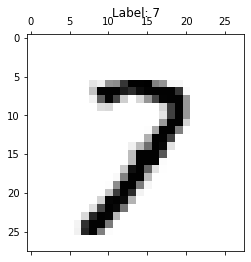

In [0]:
# Taking a random example from the training examples:
rand_example = np.random.choice(training_examples.index)
print('Plotting training sample %d, with digit value %d.' %(rand_example, training_targets.loc[rand_example]))

display.display(training_examples.loc[rand_example,:])

[_, ax] = plt.subplots()
ax.matshow(training_examples.loc[rand_example,:].values.reshape(28, 28), cmap='Greys')  # we reshape the 784 columns into numpy and then reshaped to a matrix of 28,28  # matshow, plots a matrix
ax.set_title('Label: %d' %training_targets.loc[rand_example])
ax.grid(False)

## Task 1: Build a Linear Model for MNIST

First, let's create a baseline model to compare against. The `LinearClassifier` provides a set of *k* one-vs-all classifiers, one for each of the *k* classes.

You'll notice that in addition to reporting accuracy, and plotting Log Loss over time, we also display a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix).  The confusion matrix shows which classes were misclassified as other classes. Which digits get confused for each other?

Also note that we track the model's error using the `log_loss` function. This should not be confused with the loss function internal to `LinearClassifier` that is used for training.

In [0]:
# Feature Columns:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  
  # There are 784 pixels in each image.
  return set([tf.feature_column.numeric_column('pixels', shape=784)])

Here, we'll make separate input functions for training and for prediction. We'll nest them in `create_training_input_fn()` and `create_predict_input_fn()`, respectively, so we can invoke these functions to return the corresponding `_input_fn`s to pass to our `.train()` and `.predict()` calls.

In [0]:
# Input function for training:
def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True):
  """A custom input_fn for sending MNIST data to the estimator for training.

  Args:
    features: The training features.
    labels: The training labels.
    batch_size: Batch size to use during training.

  Returns:
    A function that returns batches of training features and labels during
    training.
  """
  def _input_fn(num_epochs=None, shuffle=True):
    # Input pipelines are reset with each call to .train(). To ensure model
    # gets a good sampling of data, even when number of steps is small, we 
    # shuffle all the data before creating the Dataset object
    idx = np.random.permutation(features.index)
    raw_features = {"pixels":features.reindex(idx)}
    raw_targets = np.array(labels[idx])
   
    ds = Dataset.from_tensor_slices((raw_features,raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

In [0]:
# Input function for prediction (effectively same as above but only 1 epoch):
def create_predict_input_fn(features, labels, batch_size):
  """A custom input_fn for sending mnist data to the estimator for predictions.

  Args:
    features: The features to base predictions on.
    labels: The labels of the prediction examples.

  Returns:
    A function that returns features and labels for predictions.
  """
  def _input_fn():
    raw_features = {"pixels": features.values}
    raw_targets = np.array(labels)
    
    ds = Dataset.from_tensor_slices((raw_features, raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size)
    
        
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

In [0]:
def train_linear_classification_model(
    learning_rate,
    regularization_strength,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model for the MNIST digits dataset.
  
  In addition to training, this function also prints training progress information,
  a plot of the training and validation loss over time, and a confusion
  matrix.
  
  Args:
    learning_rate: A `float`, the learning rate to use.
    regularization_strength: A `float` that indicates the strength of the L1
       regularization. A value of `0.0` means no regularization.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing the training features.
    training_targets: A `DataFrame` containing the training labels.
    validation_examples: A `DataFrame` containing the validation features.
    validation_targets: A `DataFrame` containing the validation labels.
      
  Returns:
    The trained `LinearClassifier` object.
  """

  periods = 10

  steps_per_period = steps / periods  
  # Create the input functions.
  predict_training_input_fn = create_predict_input_fn( training_examples, training_targets, batch_size )
  predict_validation_input_fn = create_predict_input_fn( validation_examples, validation_targets, batch_size )
  training_input_fn = create_training_input_fn( training_examples, training_targets, batch_size )
  
  # Create a LinearClassifier object.
  # my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)   # does not accept regularisation
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate, l1_regularization_strength=regularization_strength)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(),
      n_classes=10,   # classifier with 10 output classes
      optimizer=my_optimizer,
      config=tf.estimator.RunConfig(keep_checkpoint_max=1)
  )

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss error (on validation data):")
  training_errors = []
  validation_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
  
    # Take a break and compute probabilities.
    training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
    training_probabilities = np.array([item['probabilities'] for item in training_predictions])    # probability for each class
    training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])   # getting the class digit
    training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)      # binary matrix representation of the input
        
    validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
    validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
    validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
    validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)    
    
    # Compute training and validation errors.
    training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)   # error between predicted digit and actual target (label)
    validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, validation_log_loss))
    # Add the loss metrics from this period to our list.
    training_errors.append(training_log_loss)
    validation_errors.append(validation_log_loss)
  print("Model training finished.")
  # Remove event files to save disk space.
  _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
  
  # Calculate final predictions (not probabilities, as above).
  final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
  final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
  
  train_predictions = classifier.predict(input_fn=predict_training_input_fn)
  train_predictions = np.array([item['class_ids'][0] for item in train_predictions])  
  
  accuracy = metrics.accuracy_score(validation_targets, final_predictions)
  print("Final accuracy (on validation data): %0.2f" % accuracy)

  # Output a graph of loss metrics over periods.
  plt.figure(figsize=(15,6))
  plt.subplot(1,2,1)
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.plot(training_errors, label="training")
  plt.plot(validation_errors, label="validation")
  plt.grid()
  plt.legend()

  # Output a graph of prediction vs target:
  plt.subplot(1,2,2)
  plt.plot(train_predictions, training_targets.values, '.', label='training')
  plt.plot(final_predictions, validation_targets.values, '.', label='validation')
  plt.title('Predictions vs Labels')
  plt.xlabel('Predictied digit')
  plt.ylabel('Label digit')
  plt.grid()
  plt.show()
  
  # Output a plot of the confusion matrix.
  cm = metrics.confusion_matrix(validation_targets, final_predictions)
  # Normalize the confusion matrix by row (i.e by the number of samples
  # in each class).
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  ax = sns.heatmap(cm_normalized, cmap="bone_r")
  ax.set_aspect(1)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()

  return classifier

In [0]:
# Call the linear classifier training model:
learning_rate = 0.05   # 0.02
steps = 1000   # 100
batch_size = 50   # 10
regularization_strength = 0.8

linear_classifier = train_linear_classification_model(
    learning_rate=learning_rate,
    regularization_strength=regularization_strength,
    steps=steps,
    batch_size=batch_size,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [0]:
# Getting and predicting test_samples from the test set randomly:
predict_test_input_fn = create_predict_input_fn( test_examples, test_targets, batch_size )
test_predictions = linear_classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['class_ids'][0] for item in test_predictions])
idx = np.random.permutation(test_examples.index)   # this gets the df index, not the row number!
# display.display(test_targets.head(10))
# display.display(test_predictions[:10])
# display.display(idx[:10])

# Plotting a few examples from the randomly chosen test set in a subplot:
test_samples_dim = [3,3]  # number of digit to plot in a square
count = 0
# plt.figure(figsize=(15,15))
[fig, axes] = plt.subplots(nrows=int(test_samples_dim[0]), ncols=int(test_samples_dim[1]), figsize=(12,12))
for i in range(0,test_samples_dim[0],1) :
  for j in range(0,test_samples_dim[1],1) :

    # print('Plotting test sample digit number %d' %(count+1))
    # plt.subplot(3,3,count+1)  #test_samples_dim[0], test_samples_dim[1], count+1)
    # plt.matshow(test_examples.loc[idx[count],:].values.reshape(28, 28), cmap='Greys')  # we reshape the 784 columns into numpy and then reshaped to a matrix of 28,28  # matshow, plots a matrix
    # # plt.title( 'True Label: %d, Predicted Label: %d' %(test_targets.loc[idx[count]], test_predictions.loc[idx[count]]) )
    # row_idx = test_targets.index.get_loc(idx[count])  # getting the row number from the index
    # plt.title( 'True Label: %d, Predicted Label: %d' %(test_targets.loc[idx[count]], test_predictions[row_idx]) )
    # plt.grid(False)
    
    axes[i,j].matshow(test_examples.loc[idx[count],:].values.reshape(28, 28), cmap='Greys')  # we reshape the 784 columns into numpy and then reshaped to a matrix of 28,28  # matshow, plots a matrix
    row_idx = test_targets.index.get_loc(idx[count])  # getting the row number from the index
    axes[i,j].set_title( 'True Label: %d, Predicted Label: %d' %(test_targets.loc[idx[count]], test_predictions[row_idx]) )
    axes[i,j].grid(False)
                 
    count += 1

plt.show()



NameError: ignored

## Task 2: Replace the Linear Classifier with a Neural Network

**Replace the LinearClassifier above with a [`DNNClassifier`](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier) and find a parameter combination that gives 0.95 or better accuracy.**

You may wish to experiment with additional regularization methods, such as dropout. These additional regularization methods are documented in the comments for the `DNNClassifier` class.

In [0]:
def train_dnn_classification_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a DNN classification model for the MNIST digits dataset.
  
  In addition to training, this function also prints training progress information,
  a plot of the training and validation loss over time, and a confusion
  matrix.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use. Must include the learning rate in it.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing the training features.
    training_targets: A `DataFrame` containing the training labels.
    validation_examples: A `DataFrame` containing the validation features.
    validation_targets: A `DataFrame` containing the validation labels.
      
  Returns:
    A `DNNClassifier` object trained on the training data.
  """

  periods = 10

  steps_per_period = steps / periods  
  # Create the input functions.
  predict_training_input_fn = create_predict_input_fn( training_examples, training_targets, batch_size )
  predict_validation_input_fn = create_predict_input_fn( validation_examples, validation_targets, batch_size )
  training_input_fn = create_training_input_fn( training_examples, training_targets, batch_size )
  
  # # Create feature columns.
  # feature_columns = [tf.feature_column.numeric_column('pixels', shape=784)]

  # Create a LinearClassifier object.
  # my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  classifier = tf.estimator.DNNClassifier(
      hidden_units=hidden_units,
      feature_columns=construct_feature_columns(),
      # feature_columns=feature_columns,   # alternative
      n_classes=10,   # classifier with 10 output classes
      optimizer=my_optimizer,
      # activation_fn = relu
      # dropoiut = 0.1,   #the probability we will drop out a given coordinate.
      config=tf.estimator.RunConfig(keep_checkpoint_max=1)
  )

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss error (on validation data):")
  training_errors = []
  validation_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
  
    # Take a break and compute probabilities.
    training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
    training_probabilities = np.array([item['probabilities'] for item in training_predictions])    # probability for each class
    training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])   # getting the class digit
    training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)      # binary matrix representation of the input
        
    validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
    validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
    validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
    validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)    
    
    # Compute training and validation errors.  
    # Attention! metrics.log_loss needs the prediction vectors in binary mode. Hence the one-hot!!!  The labels in y_pred are assumed to be ordered alphabetically, as done by preprocessing.LabelBinarizer
    training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)   # error between predicted digit probabilities and actual target (label)
    validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, validation_log_loss))
    # Add the loss metrics from this period to our list.
    training_errors.append(training_log_loss)
    validation_errors.append(validation_log_loss)
  print("Model training finished.")
  # Remove event files to save disk space.
  _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
  
  # Calculate final predictions (not probabilities, as above).
  final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
  final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
  
  train_predictions = classifier.predict(input_fn=predict_training_input_fn)
  train_predictions = np.array([item['class_ids'][0] for item in train_predictions])  
  
  accuracy = metrics.accuracy_score(validation_targets, final_predictions)
  print("Final accuracy (on validation data): %0.2f" % accuracy)

  # Output a graph of loss metrics over periods.
  plt.figure(figsize=(15,6))
  plt.subplot(1,2,1)
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.plot(training_errors, label="training")
  plt.plot(validation_errors, label="validation")
  plt.grid()
  plt.legend()

  # Output a graph of prediction vs target:
  plt.subplot(1,2,2)
  plt.plot(train_predictions, training_targets.values, '.', label='training')
  plt.plot(final_predictions, validation_targets.values, '.', label='validation')
  plt.title('Predictions vs Labels')
  plt.xlabel('Predictied digit')
  plt.ylabel('Label digit')
  plt.grid()
  plt.show()
  
  # Output a plot of the confusion matrix.
  cm = metrics.confusion_matrix(validation_targets, final_predictions)
  # Normalize the confusion matrix by row (i.e by the number of samples
  # in each class).
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  ax = sns.heatmap(cm_normalized, cmap="bone_r")
  ax.set_aspect(1)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()

  return classifier

Training model...
LogLoss error (on validation data):
  period 00 : 2.10
  period 01 : 1.80
  period 02 : 1.70
  period 03 : 1.77
  period 04 : 1.77
  period 05 : 1.77
  period 06 : 1.80
  period 07 : 1.70
  period 08 : 1.73
  period 09 : 1.73
Model training finished.
Final accuracy (on validation data): 0.95


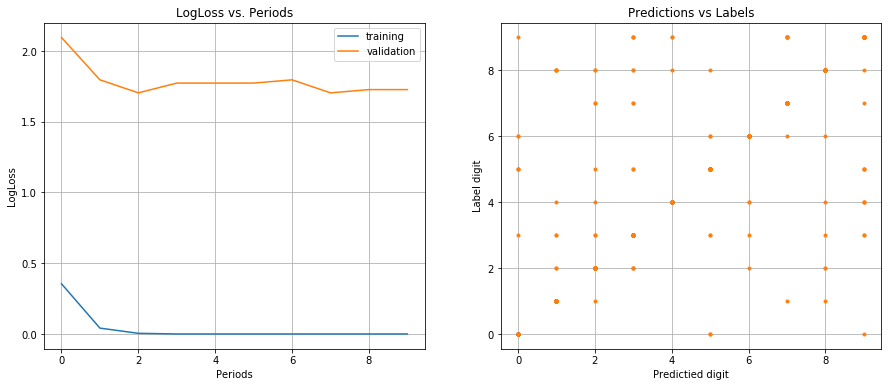

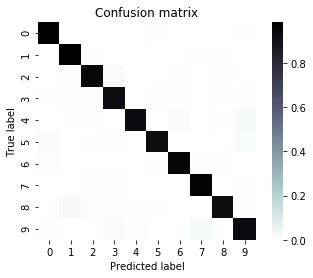

In [0]:
# Call the DNN classifier model:
learning_rate = 0.03   # 0.001 0.05
# my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)  # Gradient Descent Optimiser
my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
steps = 8000   # 1000
batch_size = 100   # 30
hidden_units = [100]    # [10] [100,100]  # units for each hidden layer
# No need to normalise features in this classifier case.

dnn_classifier = train_dnn_classification_model(
    my_optimizer=my_optimizer,
    steps=steps,
    batch_size=batch_size,
    hidden_units=hidden_units,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

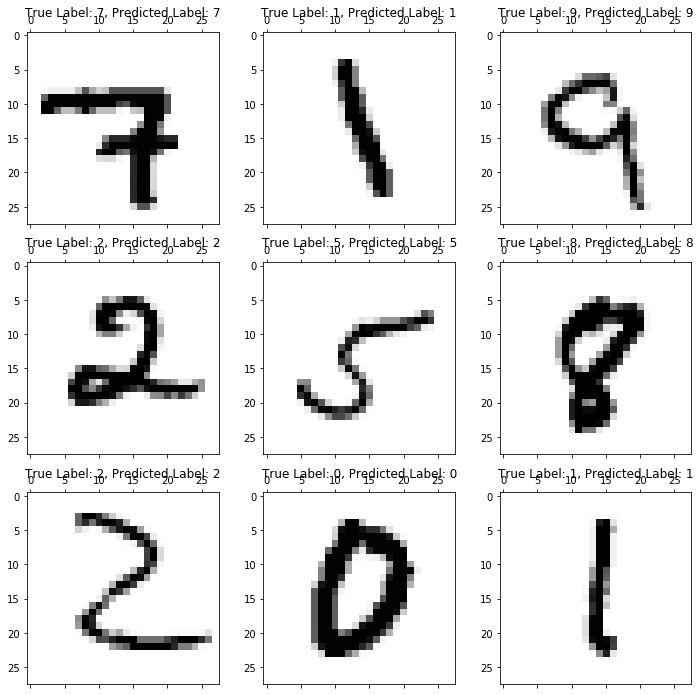

In [0]:
# Getting and predicting test_samples from the test set randomly:
predict_test_input_fn = create_predict_input_fn( test_examples, test_targets, batch_size )
test_predictions = dnn_classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['class_ids'][0] for item in test_predictions])
idx = np.random.permutation(test_examples.index)   # this gets the df index, not the row number!
# display.display(test_targets.head(10))
# display.display(test_predictions[:10])
# display.display(idx[:10])

# Plotting a few examples from the randomly chosen test set in a subplot:
test_samples_dim = [3,3]  # number of digit to plot in a square
count = 0
[fig, axes] = plt.subplots(nrows=int(test_samples_dim[0]), ncols=int(test_samples_dim[1]), figsize=(12,12))
for i in range(0,test_samples_dim[0],1) :
  for j in range(0,test_samples_dim[1],1) :

    axes[i,j].matshow(test_examples.loc[idx[count],:].values.reshape(28, 28), cmap='Greys')  # we reshape the 784 columns into numpy and then reshaped to a matrix of 28,28  # matshow, plots a matrix
    row_idx = test_targets.index.get_loc(idx[count])  # getting the row number from the index
    axes[i,j].set_title( 'True Label: %d, Predicted Label: %d' %(test_targets.loc[idx[count]], test_predictions[row_idx]) )
    axes[i,j].grid(False)
                 
    count += 1

plt.show()



## Check that we have not over-fit the data wiht the MNIST TEST set:

In [0]:
# Loading the MNIST Test dataset:
mnist_test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/mnist_test.csv", sep=',', header=None)

mnist_test_df = mnist_test_df.reindex(np.random.permutation(mnist_test_df.index))

[test_targets, test_examples] = parse_labels_and_features(mnist_test_df)

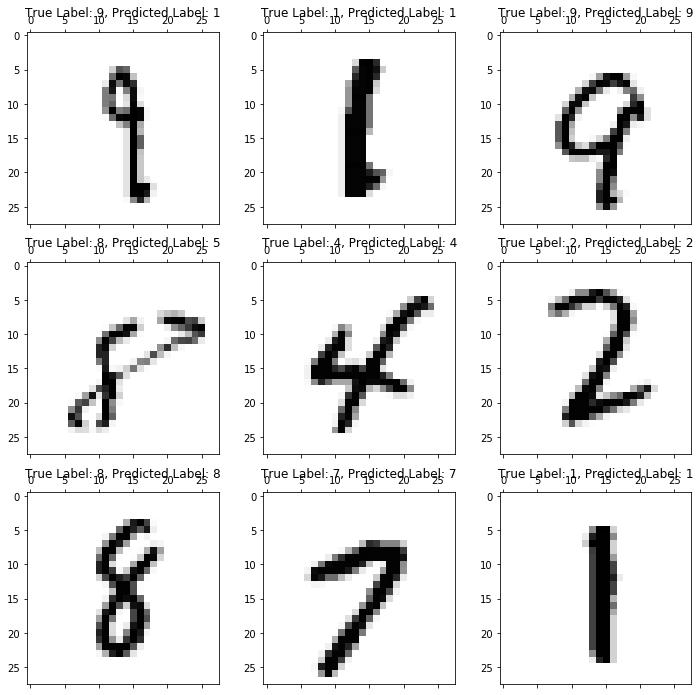

Final accuracy (on Test data): 0.95


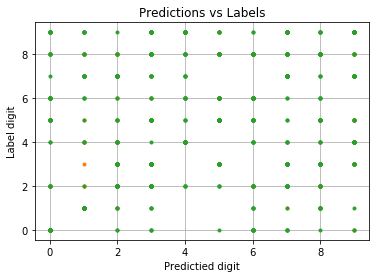

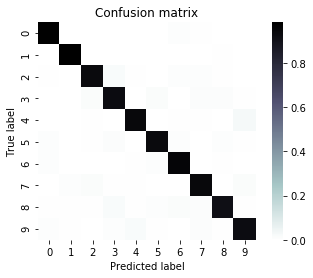

In [0]:
# Getting and predicting test_samples from the test set randomly:
predict_test_input_fn = create_predict_input_fn( test_examples, test_targets, batch_size )
test_predictions = dnn_classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['class_ids'][0] for item in test_predictions])
idx = np.random.permutation(test_examples.index)   # this gets the df index, not the row number!
# display.display(test_targets.head(10))
# display.display(test_predictions[:10])
# display.display(idx[:10])

# Plotting a few examples from the randomly chosen test set in a subplot:
test_samples_dim = [3,3]  # number of digit to plot in a square
count = 0
[fig, axes] = plt.subplots(nrows=int(test_samples_dim[0]), ncols=int(test_samples_dim[1]), figsize=(12,12))
for i in range(0,test_samples_dim[0],1) :
  for j in range(0,test_samples_dim[1],1) :

    axes[i,j].matshow(test_examples.loc[idx[count],:].values.reshape(28, 28), cmap='Greys')  # we reshape the 784 columns into numpy and then reshaped to a matrix of 28,28  # matshow, plots a matrix
    row_idx = test_targets.index.get_loc(idx[count])  # getting the row number from the index
    axes[i,j].set_title( 'True Label: %d, Predicted Label: %d' %(test_targets.loc[idx[count]], test_predictions[row_idx]) )
    axes[i,j].grid(False)
                 
    count += 1

plt.show()


# Accuracy score on the Test data:
accuracy = metrics.accuracy_score(test_targets, test_predictions)
print("Final accuracy (on Test data): %0.2f" % accuracy)

# Predictions for Training and Validation tests:
predict_training_input_fn = create_predict_input_fn( training_examples, training_targets, batch_size )
training_predictions = dnn_classifier.predict(input_fn=predict_training_input_fn)
training_predictions = np.array([item['class_ids'][0] for item in training_predictions])

predict_validation_input_fn = create_predict_input_fn( validation_examples, validation_targets, batch_size )
validation_predictions = dnn_classifier.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['class_ids'][0] for item in validation_predictions])

# Output a graph of prediction vs target:
plt.plot(training_predictions, training_targets.values, '.', label='training')
plt.plot(validation_predictions, validation_targets.values, '.', label='validation')
plt.plot(test_predictions, test_targets.values, '.', label='test')
plt.title('Predictions vs Labels')
plt.xlabel('Predictied digit')
plt.ylabel('Label digit')
plt.grid()
plt.show()
  
# Output a plot of the confusion matrix.
cm = metrics.confusion_matrix(test_targets, test_predictions)
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class).
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(cm_normalized, cmap="bone_r")
ax.set_aspect(1)
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()



## Task 3: Visualize the weights of the first hidden layer.

Let's take a few minutes to dig into our neural network and see what it has learned by accessing the `weights_` attribute of our model.

The input layer of our model has `784` weights corresponding to the `28×28` pixel input images. The first hidden layer will have `784×N` weights where `N` is the number of nodes in that layer. We can turn those weights back into `28×28` images by *reshaping* each of the `N` `1×784` arrays of weights into `N` arrays of size `28×28`.

Run the following cell to plot the weights. Note that this cell requires that a `DNNClassifier` called "classifier" has already been trained.

['dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adagrad', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adagrad', 'dnn/hiddenlayer_1/bias', 'dnn/hiddenlayer_1/bias/t_0/Adagrad', 'dnn/hiddenlayer_1/kernel', 'dnn/hiddenlayer_1/kernel/t_0/Adagrad', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adagrad', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adagrad', 'global_step']
weights0 shape: (784, 50)


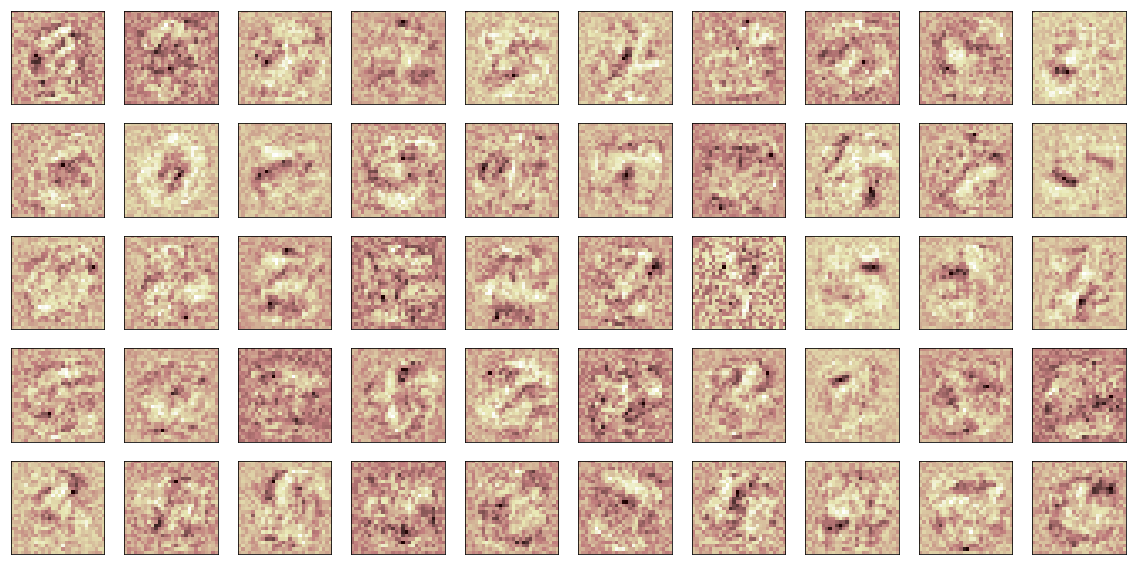

In [0]:
print(dnn_classifier.get_variable_names())

weights0 = dnn_classifier.get_variable_value("dnn/hiddenlayer_0/kernel")

print("weights0 shape:", weights0.shape)

num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(20, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    # Weights in coef is reshaped from 1x784 to 28x28.
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.pink)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

The first hidden layer of the neural network should be modeling some pretty low level features, so visualizing the weights will probably just show some fuzzy blobs or possibly a few parts of digits.  You may also see some neurons that are essentially noise -- these are either unconverged or they are being ignored by higher layers.

It can be interesting to stop training at different numbers of iterations and see the effect.